In [14]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import math
import torch.nn.functional as F
import torchvision.models as models

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
import os
from torchvision.utils import save_image

sample_dir = 'samples'
os.makedirs(sample_dir, exist_ok=True)

### We first work on a 2D dataset with size 28x28

In [5]:
data_flag = 'chestmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 128
lr = 5e-5
image_size = 28 * 28

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

### First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [23]:
# preprocessing
data_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor()
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)
z_dim = 32

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [24]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset ChestMNIST of size 28 (chestmnist)
    Number of datapoints: 78468
    Root location: /home/gorkem/.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST of size 28 (chestmnist)
    Number of datapoints: 22433
 

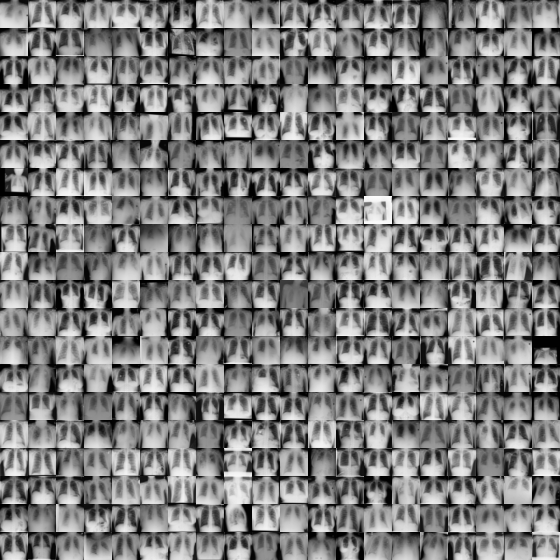

In [25]:
# montage

train_dataset.montage(length=20)

# Then, we define a basic VAE.

In [26]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [27]:
class UnFlatten(nn.Module):
    def forward(self, x):
        # Adjusted for 7x7 spatial dimensions, 128 channels
        return x.view(x.size(0), 128, 7, 7)

In [28]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch = z_mean.shape[0]
        dim = z_mean.shape[1]
        epsilon = torch.randn(batch, dim).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [45]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)


In [46]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.initial = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # no downsampling yet

        self.res1 = ResidualBlock(32, 64, downsample=True)   # 28x28 → 14x14
        self.res2 = ResidualBlock(64, 128, downsample=True)  # 14x14 → 7x7

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7 * 7 * 128, 512)
        self.z_mean = nn.Linear(512, latent_dim)
        self.z_log_var = nn.Linear(512, latent_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.relu(self.initial(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z


In [47]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 7 * 7 * 128)
        self.unflatten = nn.Unflatten(1, (128, 7, 7))

        self.res1 = ResidualBlock(128, 128)
        self.res2 = ResidualBlock(128, 64)
        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 7→14
        self.bn1 = nn.BatchNorm2d(64)

        self.res3 = ResidualBlock(64, 32)
        self.upsample2 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)  # 14→28
        self.bn2 = nn.BatchNorm2d(32)

        self.final_res = ResidualBlock(32, 16)
        self.output_conv = nn.Conv2d(16, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = self.unflatten(x)

        x = self.res1(x)
        x = self.res2(x)
        x = F.relu(self.bn1(self.upsample1(x)))

        x = self.res3(x)
        x = F.relu(self.bn2(self.upsample2(x)))

        x = self.final_res(x)
        x = torch.sigmoid(self.output_conv(x))
        return x


In [31]:
vgg = models.vgg16(pretrained=True).features[:16] 
for param in vgg.parameters():
    param.requires_grad = False  # only feature extraction

vgg = vgg.eval()

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg
        self.criterion = nn.MSELoss()

    def forward(self, x, x_hat):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
            x_hat = x_hat.repeat(1, 3, 1, 1)

        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        x = normalize(x)
        x_hat = normalize(x_hat)

        f_x = self.vgg(x)
        f_x_hat = self.vgg(x_hat)

        return self.criterion(f_x, f_x_hat)


/home/gorkem/anaconda3/envs/vae-env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gorkem/anaconda3/envs/vae-env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# 4. VAE Model
class VAE(nn.Module):
    def __init__(self, encoder, decoder, latent_dim=128, use_perceptional_loss=True):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.use_perceptual_loss = use_perceptional_loss
        self.perceptual_loss = None

        if self.use_perceptual_loss:
            self.perceptual_loss = PerceptualLoss()            

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

    def calculate_loss(self, data, reconstruction, z_mean, z_log_var, beta=1.0):
        distortion_loss = 0

        if self.use_perceptual_loss:
            # use perceptual loss as the distortion loss term
            distortion_loss = self.perceptual_loss(data, reconstruction)
        else:
            # use reconstruction loss (MSE Loss) as the distortion loss term
            distortion_loss = F.mse_loss(reconstruction, data, reduction='sum')
            distortion_loss = torch.sum(distortion_loss, dim=(1, 2, 3)) # Sum over H, W, C
            distortion_loss = torch.mean(distortion_loss) # Mean over batch

        # KL Divergence Loss
        # kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        # kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        kl_loss = torch.mean(kl_loss)

        total_loss = distortion_loss + beta * kl_loss
        return total_loss, distortion_loss, kl_loss

# Next, we can start to train and evaluate!

In [48]:
# Device configuration
latent_dim = 32
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
vae = VAE(encoder, decoder, latent_dim=latent_dim, use_perceptional_loss=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vae.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [49]:
image_channels = 3

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    total_epoch_distortion_loss = 0.0
    total_epoch_kl_loss = 0.0
    num_batches = 0

    kl_anneal_epochs = 200
    beta = min(1.0, (epoch + 1) / kl_anneal_epochs)

    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)

        # Forward pass
        x_reconst, mu, log_var = model(x)

        loss, distortion_loss, kl_loss = model.calculate_loss(x, x_reconst, mu, log_var, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_epoch_loss += loss.item()
        total_epoch_distortion_loss += distortion_loss.item()
        total_epoch_kl_loss += kl_loss.item()
        num_batches += 1

    # Averages
    avg_total_loss = total_epoch_loss / num_batches
    avg_distortion_loss = total_epoch_distortion_loss / num_batches
    avg_kl_loss = total_epoch_kl_loss / num_batches

    print("Epoch[{}/{}], Avg Total Loss: {:.4f}, Avg Distortion Loss: {:.4f}, Avg KL Div: {:.4f} with Beta = {:.3f}"
          .format(epoch+1, NUM_EPOCHS, avg_total_loss, avg_distortion_loss, avg_kl_loss, beta))

    with torch.no_grad():
        num_samples_to_save = 10
        z_fixed = torch.randn(num_samples_to_save, model.latent_dim).to(device)
        out_sampled = model.decoder(z_fixed).view(-1, image_channels, 28, 28)
        save_image(out_sampled, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)), nrow=10)

        num_reconstruct_to_save = 10
        x_for_saving = next(iter(train_loader))[0][:num_reconstruct_to_save].to(device)
        out_reconst_for_save, _, _ = model(x_for_saving)

        x_concat_to_save = torch.cat([
            x_for_saving.view(-1, image_channels, 28, 28),
            out_reconst_for_save.view(-1, image_channels, 28, 28)
        ], dim=3)
        save_image(x_concat_to_save, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)), nrow=5)


Epoch[1/100], Avg Total Loss: 11.0638, Avg Distortion Loss: 10.6142, Avg KL Div: 89.9234 with Beta = 0.005
Epoch[2/100], Avg Total Loss: 6.6722, Avg Distortion Loss: 5.8200, Avg KL Div: 85.2141 with Beta = 0.010
Epoch[3/100], Avg Total Loss: 6.0842, Avg Distortion Loss: 4.9502, Avg KL Div: 75.5983 with Beta = 0.015
Epoch[4/100], Avg Total Loss: 5.9598, Avg Distortion Loss: 4.6316, Avg KL Div: 66.4101 with Beta = 0.020
Epoch[5/100], Avg Total Loss: 5.9456, Avg Distortion Loss: 4.4784, Avg KL Div: 58.6870 with Beta = 0.025
Epoch[6/100], Avg Total Loss: 5.9785, Avg Distortion Loss: 4.4043, Avg KL Div: 52.4712 with Beta = 0.030
Epoch[7/100], Avg Total Loss: 6.0288, Avg Distortion Loss: 4.3657, Avg KL Div: 47.5176 with Beta = 0.035
Epoch[8/100], Avg Total Loss: 6.0946, Avg Distortion Loss: 4.3503, Avg KL Div: 43.6073 with Beta = 0.040
Epoch[9/100], Avg Total Loss: 6.1670, Avg Distortion Loss: 4.3493, Avg KL Div: 40.3935 with Beta = 0.045
Epoch[10/100], Avg Total Loss: 6.2426, Avg Distortion

KeyboardInterrupt: 

Displaying a Full Batch of Original Images in a Grid:


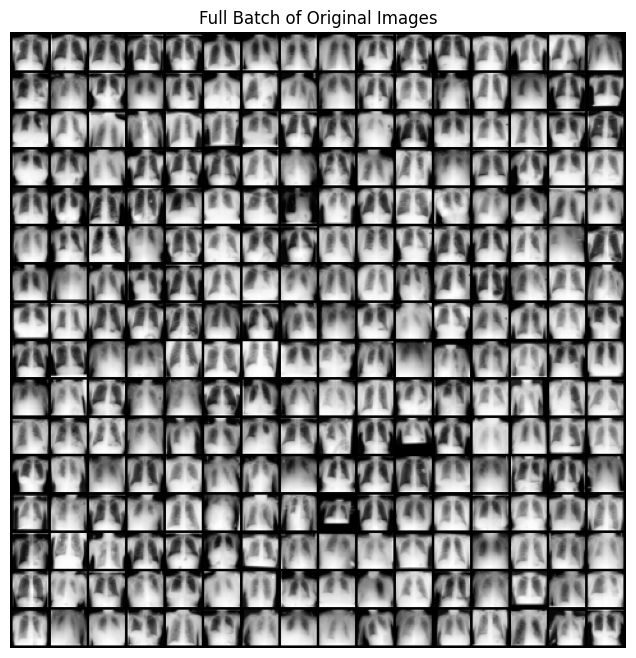


Displaying a Full Batch of Reconstructed Images in a Grid:


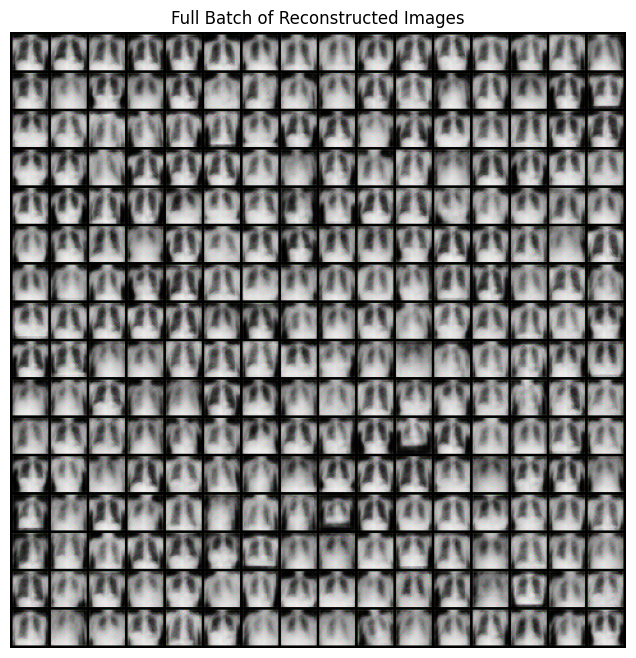


Displaying a Full Batch of Generated Images in a Grid:


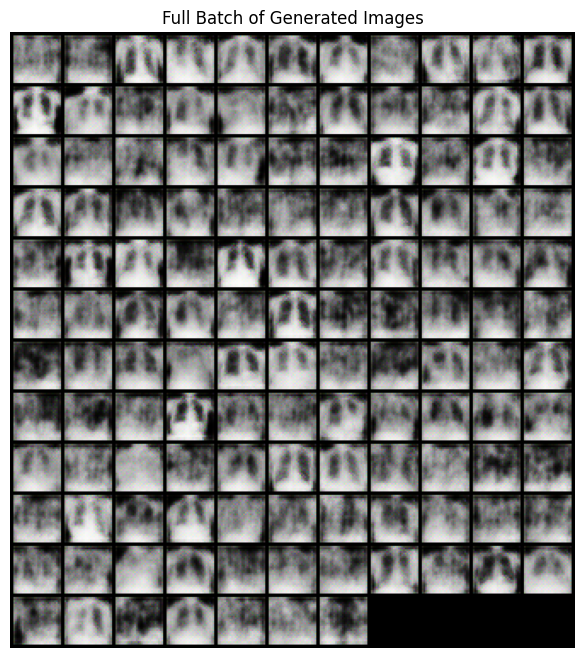

In [50]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow_tensor(img_tensor, title=None):
    """
    Displays a PyTorch image tensor.

    Args:
        img_tensor (torch.Tensor): The image tensor.
                                   Expected shape: (C, H, W) for single image
                                   or (N, C, H, W) for a batch.
                                   Assumes pixel values are in [0, 1] or can be normalized.
        title (str, optional): Title for the plot. Defaults to None.
    """
    # If it's a batch of images (4 dimensions: N, C, H, W), make a grid.
    if img_tensor.dim() == 4:
        # Determine nrow to make a somewhat square grid, or you can force it
        # For a full grid that's roughly square:
        num_images = img_tensor.shape[0]
        nrow = int(num_images**0.5) # Example: For 64 images, nrow will be 8
        if nrow == 0: nrow = 1 # Avoid division by zero for very small batches

        img_tensor = make_grid(img_tensor, nrow=nrow, normalize=True, scale_each=True)
        # normalize=True scales values to [0,1] for display, scale_each=True normalizes each image separately

    np_img = img_tensor.cpu().numpy()
    if np_img.ndim == 3 and np_img.shape[0] in [1, 3]: # Check for (C, H, W) format
        np_img = np.transpose(np_img, (1, 2, 0))
    if np_img.shape[-1] == 1: # For grayscale (H, W, 1) -> (H, W)
        np_img = np_img.squeeze(-1)

    plt.figure(figsize=(8, 8))
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# --- How to display a full batch in a grid ---

# Get a full batch from your test_loader (or train_loader)
# Ensure test_loader and device are defined from your setup
# (e.g., as in the MedMNIST data loading example)

# Example: Get the first full batch of original images
x_batch, _ = next(iter(test_loader))
x_batch = x_batch.to(device)

print("Displaying a Full Batch of Original Images in a Grid:")
imshow_tensor(x_batch, title="Full Batch of Original Images")

# You can do the same for reconstructed images or generated samples if you have them in a batch:

# Example: Get a full batch of reconstructed images (assuming your model returns N, C, H, W or N, C, D, H, W)
# This assumes your model's forward pass gives you the correct output format
with torch.no_grad():
    reconstructed_batch, _, _ = model(x_batch) # Pass the full batch
    # Ensure it's in (N, C, H, W) format for make_grid, adjust view if needed for 3D -> 2D slices
    if reconstructed_batch.dim() == 5: # If your model outputs 3D (N, C, D, H, W)
        # You would need to select a slice to make it 2D for imshow_tensor
        # For simplicity, let's take a middle slice for all images in the batch
        middle_slice_idx = reconstructed_batch.shape[2] // 2 # Middle slice in depth
        reconstructed_batch_2d = reconstructed_batch[:, :, middle_slice_idx, :, :]
        print("\nDisplaying a Full Batch of Reconstructed Slices (middle depth) in a Grid:")
        imshow_tensor(reconstructed_batch_2d, title="Full Batch of Reconstructed Slices")
    else: # It's already 4D (N, C, H, W)
        print("\nDisplaying a Full Batch of Reconstructed Images in a Grid:")
        imshow_tensor(reconstructed_batch, title="Full Batch of Reconstructed Images")

# Example: Generate a full batch of new samples
with torch.no_grad():
    num_samples_to_generate = BATCH_SIZE # Generate as many as your batch size
    z_full_batch = torch.randn(num_samples_to_generate, model.latent_dim).to(device)
    generated_batch = model.decoder(z_full_batch)
    # Adjust view based on whether your decoder outputs 2D or 3D images
    if generated_batch.dim() == 5: # If 3D (N, C, D, H, W)
        middle_slice_idx = generated_batch.shape[2] // 2
        generated_batch_2d = generated_batch[:, :, middle_slice_idx, :, :]
        print("\nDisplaying a Full Batch of Generated Slices (middle depth) in a Grid:")
        imshow_tensor(generated_batch_2d, title="Full Batch of Generated Slices")
    else: # If 2D (N, C, H, W)
        print("\nDisplaying a Full Batch of Generated Images in a Grid:")
        imshow_tensor(generated_batch, title="Full Batch of Generated Images")